In [1]:
import sys
import os
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import AstroChemNet.data_processing as dp
from AstroChemNet.inference import Inference
from AstroChemNet.loss import Loss
import AstroChemNet.data_loading as dl

project_root = os.path.abspath("../../")
os.chdir(project_root)
sys.path.insert(0, project_root)

from configs.general import GeneralConfig
from configs.autoencoder import AEConfig
from configs.emulator import EMConfig
from nn_architectures.autoencoder import Autoencoder, load_autoencoder
from nn_architectures.emulator import Emulator, load_emulator

In [2]:
autoencoder = load_autoencoder(Autoencoder, GeneralConfig, AEConfig, inference=True)
emulator = load_emulator(Emulator, GeneralConfig, EMConfig, inference=True)

processing = dp.Processing(GeneralConfig, AEConfig)
inference = Inference(GeneralConfig, processing, autoencoder, emulator)

Loading Pretrained Model
Setting Autoencoder to Inference Mode
Loading Pretrained Model
Setting Emulator to Inference Mode
Latents MinMax: -0.16997122764587402, 31.517663955688477


In [3]:
validation_dataset, validation_indices = dl.load_tensors_from_hdf5(
    GeneralConfig, category="validation_seq"
)

validation_Dataset = dl.EmulatorSequenceDataset(
    GeneralConfig, AEConfig, validation_dataset, validation_indices
)
del validation_indices

validation_dataloader = dl.tensor_to_dataloader(EMConfig, validation_Dataset)

Data_matrix Memory usage: 1200.803 MB
Indices_matrix Memory usage: 158.983 MB
Dataset Size: 173652



In [4]:
err = torch.zeros(
    EMConfig.window_size - 1, GeneralConfig.num_species, device=GeneralConfig.device
)
cons_err = torch.zeros(
    EMConfig.window_size - 1, 9, device=GeneralConfig.device
)
for i, (phys, latents, targets) in enumerate(validation_dataloader):
    latents = latents.to(GeneralConfig.device)
    targets = targets.to(GeneralConfig.device)
    targets = processing.inverse_abundances_scaling(targets)
    latents = processing.inverse_latent_components_scaling(latents)
    outputs = inference.emulate(phys, latents, skip_encoder=True)
    j = torch.abs(targets - outputs) / targets
    err += j.mean(dim=0)
    
    z1 = targets @ GeneralConfig.stoichiometric_matrix
    z2 = outputs @ GeneralConfig.stoichiometric_matrix
    j2 = torch.abs(z1 - z2) / z1
    cons_err += j2.mean(dim=0)
    
err /= len(validation_dataloader)

In [528]:
print(f"Mean Error: {err.mean() * 100:.2f}%")
print(f"STD of Mean Error: {err.mean(dim=0).std() * 100:.2f}%")
print(f"Max Species Error: {err.mean(dim=0).max() * 100:.2f}%")
print(f"Mean Conservation Error: {cons_err.mean().mean() * 100:.2f}%")

Mean Error: 2.71%
STD of Mean Error: 2.15%
Max Species Error: 13.71%
Mean Conservation Error: 11.63%


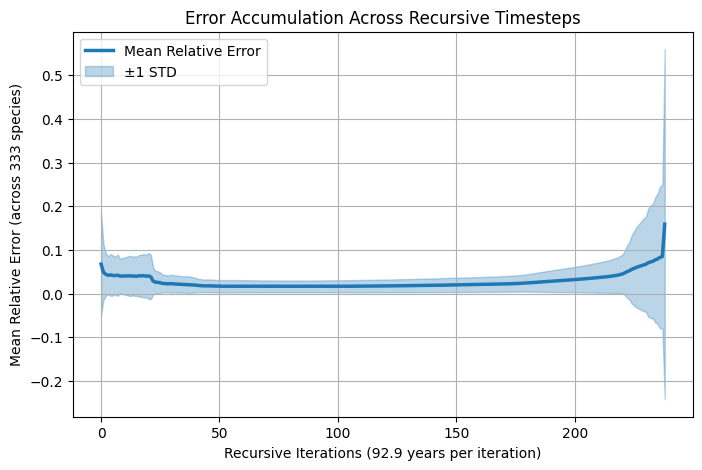

In [ ]:
timesteps = np.arange(1, EMConfig.window_size)
err_mean = err.mean(dim=1).cpu().numpy()
err_std = err.std(dim=1).cpu().numpy()

plt.figure(figsize=(8, 5))  # wider plot

plt.plot(
    timesteps,
    err_mean,
    label="Mean Relative Error",
    linewidth=2.5,   # thicker line
    color="C0"       # optional: force a consistent color
)
plt.fill_between(
    timesteps,
    err_mean - err_std,
    err_mean + err_std,
    alpha=0.3,
    color="C0",      # match line color
    label="±1 STD"
)

plt.title("Error Accumulation Across Recursive Timesteps")
plt.grid()
plt.xlabel("Recursive Iterations (92.9 years per iteration)")
plt.ylabel("Mean Relative Error (across 333 species)")
plt.legend()
plt.show()

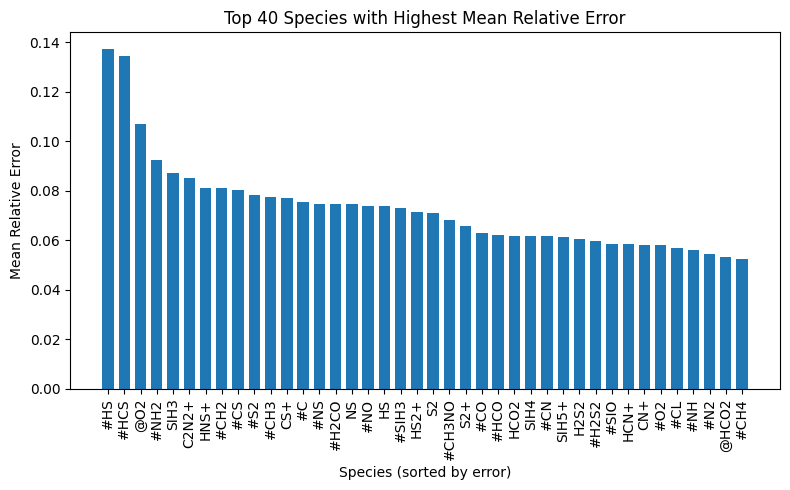

In [20]:
err_mean_per_species = err.mean(dim=0).cpu().numpy()

sorted_idx = np.argsort(err_mean_per_species)[::-1]
worst_idx = sorted_idx[:40]
worst_errs = err_mean_per_species[worst_idx]

species_names = [GeneralConfig.species[i] for i in worst_idx]

# Bar chart
plt.figure(figsize=(8, 5))
plt.bar(range(len(worst_errs)), worst_errs, width=0.7)

plt.title("Top 40 Species with Highest Mean Relative Error")
plt.xlabel("Species (sorted by error)")
plt.ylabel("Mean Relative Error")
plt.xticks(range(len(worst_errs)), species_names, rotation=90)
plt.tight_layout()
plt.show()


In [21]:
training_np, validation_np = dl.load_datasets(GeneralConfig, EMConfig.columns)
del training_np

In [514]:
# col_variation = np.log10(df_model[GeneralConfig.species]).std()
# col_variation = np.log10(df_model[GeneralConfig.species]).diff().median()
# col_variation = np.log10(df_model[GeneralConfig.species]).diff().abs().mean()
col_variation = (
    np.log10(df_model[GeneralConfig.species])
    .rolling(window=3, min_periods=2)
    .std()
    .mean()
)
species_of_interest = col_variation.nlargest(25).index.tolist()

2936


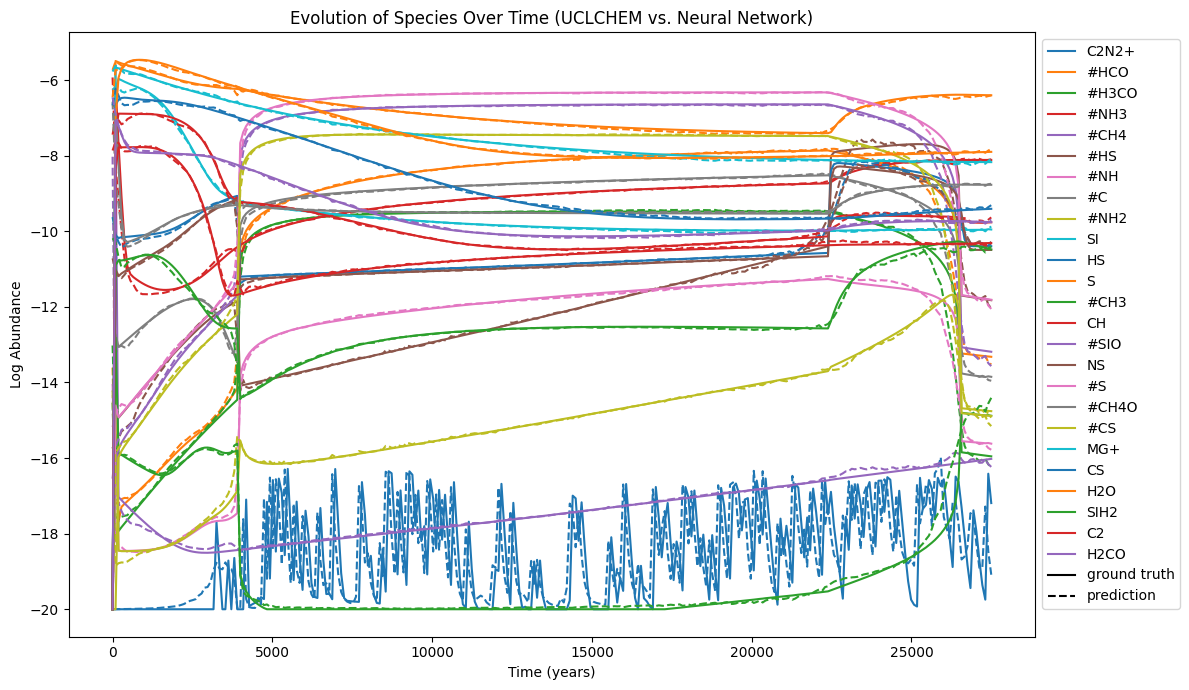

In [516]:

model_of_interest = random.randint(0, 2993)
print(model_of_interest)
unique_models = np.unique(validation_np[:, 1])

df_model = pd.DataFrame(
    validation_np[validation_np[:, 1] == unique_models[model_of_interest]],
    columns=GeneralConfig.metadata
    + GeneralConfig.phys
    + GeneralConfig.species,
)

z = df_model[GeneralConfig.phys].to_numpy()
processing.physical_parameter_scaling(z)
df_model[GeneralConfig.phys] = z

results = (
    inference.emulate(
        df_model[GeneralConfig.phys].to_numpy()[None, :, :],
        df_model[GeneralConfig.species].to_numpy()[:1],
    )
    .cpu()
    .numpy()
)
df_results = pd.DataFrame(results.squeeze(0), columns=GeneralConfig.species)

fig, ax = plt.subplots(figsize=(12, 7))

for species in species_of_interest:
    if species in df_model.columns:
        x_log_abundance = np.log10(df_model[species])
        x_log_abundance = np.maximum(x_log_abundance, -20)
        y_log_abundance = np.log10(df_results[species])
        y_log_abundance = np.maximum(y_log_abundance, -20)

        (line_actual,) = ax.plot(df_model["Time"], x_log_abundance, label=species)
        ax.plot(
            df_model["Time"],
            y_log_abundance,
            linestyle="--",
            color=line_actual.get_color(),
        )

(dummy_line,) = ax.plot([], [], linestyle="-", color="black", label="ground truth")
(dummy_line,) = ax.plot([], [], linestyle="--", color="black", label="prediction")

ax.set_xlabel("Time (years)")
ax.set_ylabel("Log Abundance")
ax.set_title("Evolution of Species Over Time (UCLCHEM vs. Neural Network)")
ax.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.tight_layout()
plt.show()

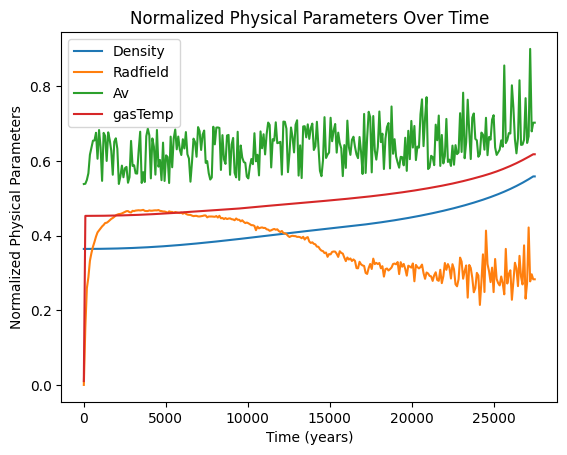

    Density  Radfield        Av   gasTemp
0  0.364393  0.000000  0.538286  0.010353
1  0.364395  0.155546  0.539089  0.452960
2  0.364403  0.259082  0.549305  0.452966
3  0.364415  0.288727  0.567159  0.452976
4  0.364432  0.332530  0.616914  0.452990


In [36]:
for column in GeneralConfig.phys:
    plt.plot(df_model["Time"], df_model[column], label=column)

plt.title("Normalized Physical Parameters Over Time")
plt.xlabel("Time (years)")
plt.ylabel("Normalized Physical Parameters")
plt.legend()
plt.show()

print(df_model[GeneralConfig.phys].head())